In [1]:
#https://www.geeksforgeeks.org/machine-learning/random-forest-hyperparameter-tuning-in-python/
#https://www.youtube.com/watch?v=AZNrn9ihZkw
#https://www.geeksforgeeks.org/dsa/random-forest-classifier-using-scikit-learn/
#https://medium.com/data-science/random-forest-explained-a-visual-guide-with-code-examples-9f736a6e1b3c
#cross validation: https://ploomber.io/blog/nested-cv/
#https://www.blog.trainindata.com/random-forest-with-grid-search/#:~:text=Grid%20Search%20uses%20K%2Dfold,for%20each%20combination%20of%20hyperparameters.
#handling imbalanced data with oversampling https://www.youtube.com/watch?v=4SivdTLIwHc 
#class imbalance https://www.youtube.com/watch?v=flhjn6e6wnY
#multiple scoring and the roc curve: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

Part 1. Importing Libraries

In [2]:
# Data Processing
import pandas as pd
import numpy as np

# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import sklearn
import warnings

warnings.filterwarnings('ignore')

Part 2. Importing the dataset

In [3]:
df = pd.read_csv('combined_accidents_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   publish_date                232 non-null    object 
 1   content                     232 non-null    object 
 2   time_24h                    232 non-null    object 
 3   corrected_date              232 non-null    object 
 4   injury_severity             232 non-null    object 
 5   affected_party              232 non-null    object 
 6   primary_accident_type_code  232 non-null    object 
 7   age                         232 non-null    object 
 8   ages_after_driven_by        232 non-null    object 
 9   driver_age_min              232 non-null    float64
 10  location                    229 non-null    object 
 11  street                      229 non-null    object 
 12  locality                    160 non-null    object 
 13  day_of_week_num             232 non

In [4]:
df.isnull().sum()
#location, street and locality have missing values, but it will not be used for predictions. Other columns have no missing values

publish_date                   0
content                        0
time_24h                       0
corrected_date                 0
injury_severity                0
affected_party                 0
primary_accident_type_code     0
age                            0
ages_after_driven_by           0
driver_age_min                 0
location                       3
street                         3
locality                      72
day_of_week_num                0
rush_hour                      0
rain_today                     0
rain_last_3h                   0
roadworks_nearby               0
vehicle_type_score             0
age_min_encoded                0
age_list                       0
time_period                    0
dtype: int64

<Axes: ylabel='count'>

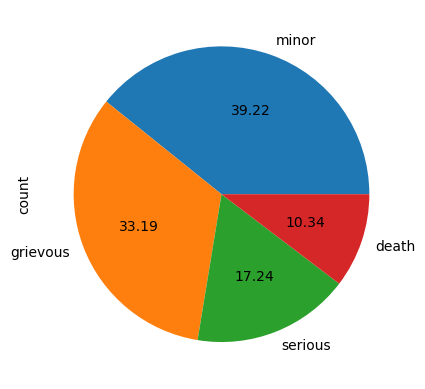

In [5]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

<Axes: ylabel='count'>

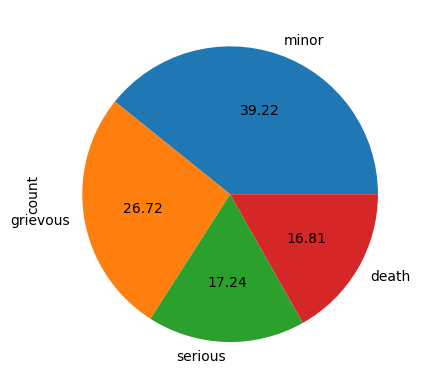

In [6]:
# to balance the dataset out and to improve predictions, the following assumptions are made:
#1. Grievous and serious injuries are merged into one class
#2. 20% of grievous injuries are reclassified as death. According to the WHO, the accident is considered fatal, if death occured 
# within a month since the accident (https://cdn.who.int/media/docs/default-source/documents/health-topics/road-traffic-injuries/definition-of-a-road-traffic-death-by-who-and-the-health-sector.pdf?sfvrsn=24c83ea3_3)
# According to this study (in the US) (https://pmc.ncbi.nlm.nih.gov/articles/PMC3603725/), 20% of grievously injured people die within a month from the accident.
# random reclassification of 20% grievous injuries to death is done only once, for reproducibility.
# The reclassed dataset is written into a new file and then loaded for processing.

#idx_grievous = df.loc[(df['injury_severity']  == 'grievous')].index
#num_idx = round(len(idx_grievous)*0.2)
#index_replace = np.random.choice(idx_grievous, num_idx, replace=False)  
#df.loc[index_replace, 'injury_severity'] = 'death'
#df_balanced = df

#saving the new classes into a new file
#output_file = "combined_accidents_balanced.csv"
#df_balanced.to_csv(output_file, index=False)

df = pd.read_csv('combined_accidents_balanced.csv')
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

Part 3. Feature Encoding 

Random Forests do not require one-hot encoding. The model might perform worse because one-hot encoding adds more columns, meaning a tree would need to split into more leaves, making classification more difficult. For this model, ordinal encoding was chosen. Categorical values need not be scaled, so no scaling was done either.

injury_severity
1    102
0     91
2     39
Name: count, dtype: int64


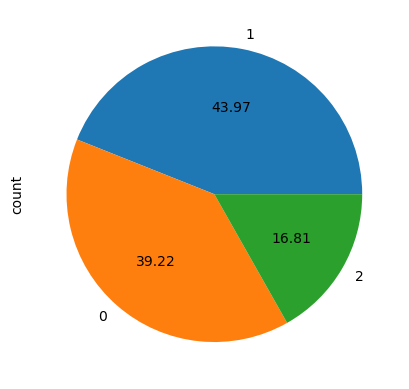

In [7]:
#encoding the injury severity column
df_sel = df[['injury_severity','affected_party','primary_accident_type_code','day_of_week_num','rain_today','vehicle_type_score','age_min_encoded','rush_hour','time_period']]
#ordinal_mapping_injury = {'minor':0,'serious':1,'grievous':2, 'death':3}
ordinal_mapping_injury = {'minor':0,'serious':1,'grievous':1, 'death':2}
df_sel['injury_severity'] = df_sel['injury_severity'].map(ordinal_mapping_injury)

df_sel['injury_severity'].value_counts().plot.pie(autopct='%.2f')
print(df_sel['injury_severity'].value_counts())

In [8]:
print(df_sel['injury_severity'].value_counts())

injury_severity
1    102
0     91
2     39
Name: count, dtype: int64


In [9]:
#encoding the affected party column 
ordinal_mapping_ap = {'pedestrian':0,'cyclist':1,'motorcyclist':2, 'driver':3}
df_sel['affected_party'] = df_sel['affected_party'].map(ordinal_mapping_ap)
df_sel['affected_party']

0      0
1      2
2      0
3      3
4      3
      ..
227    0
228    2
229    3
230    2
231    3
Name: affected_party, Length: 232, dtype: int64

In [10]:
#encoding the accident type code column 
ordinal_mapping_at = {'FXOBJ':0,'PED':1,'COLL':2, 'OTH':3}
df_sel['primary_accident_type_code'] = df_sel['primary_accident_type_code'].map(ordinal_mapping_at)
df_sel['primary_accident_type_code']

0      1
1      0
2      1
3      2
4      2
      ..
227    1
228    2
229    2
230    2
231    2
Name: primary_accident_type_code, Length: 232, dtype: int64

In [11]:
#encoding the accident type code column 
df_sel['rain_today'] = df_sel['rain_today'].astype(int)
df_sel['rain_today']

0      0
1      0
2      0
3      0
4      0
      ..
227    1
228    0
229    0
230    0
231    0
Name: rain_today, Length: 232, dtype: int32

In [12]:
#encoding time period
ordinal_mapping_tp = {'Night':0,'Morning':1,'Afternoon':2, 'Evening':3}
df_sel['time_period'] = df_sel['time_period'].map(ordinal_mapping_tp)
df_sel['time_period']

0      1
1      3
2      3
3      3
4      3
      ..
227    1
228    1
229    1
230    1
231    1
Name: time_period, Length: 232, dtype: int64

In [13]:
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   injury_severity             232 non-null    int64
 1   affected_party              232 non-null    int64
 2   primary_accident_type_code  232 non-null    int64
 3   day_of_week_num             232 non-null    int64
 4   rain_today                  232 non-null    int32
 5   vehicle_type_score          232 non-null    int64
 6   age_min_encoded             232 non-null    int64
 7   rush_hour                   232 non-null    int64
 8   time_period                 232 non-null    int64
dtypes: int32(1), int64(8)
memory usage: 15.5 KB


In [ ]:
#change the values to dummies

Part 3. Data splitting into train, validation and test

In [14]:
#splitting data into train, validate and test sets (https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test)

def split_stratified_into_train_val_test(df_input, stratify_colname='injury_severity',
                                         frac_train=0.7, frac_val=0.15, frac_test=0.15,
                                         random_state=42):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

train, val, test = split_stratified_into_train_val_test(df_sel, stratify_colname='injury_severity', frac_train=0.6, frac_val=0.2, frac_test=0.20)

# Show the number of observations for the train, validate and test dataframes
print('Number of observations in the training set:', len(train))
print('Number of observations in the validate set:',len(val))
print('Number of observations in the validate set:',len(test))


Number of observations in the training set: 139
Number of observations in the validate set: 46
Number of observations in the validate set: 47


In [15]:
#splitting data into X (features) and y (target)
#x_params = ['primary_accident_type_code','affected_party','day_of_week_num','rain_today','vehicle_type_score','age_min_encoded','time_period']
x_params = ['primary_accident_type_code','affected_party','rain_today','vehicle_type_score','age_min_encoded']

y_train = train['injury_severity']
X_train = train[x_params]

y_val = val['injury_severity']
X_val = val[x_params]

y_test = test['injury_severity']
X_test = test[x_params]


In [16]:
y_test.value_counts()

injury_severity
1    21
0    18
2     8
Name: count, dtype: int64

In [17]:
y_val.value_counts()

injury_severity
1    20
0    18
2     8
Name: count, dtype: int64

In [18]:
y_train.value_counts()

injury_severity
1    61
0    55
2    23
Name: count, dtype: int64

Part 4a. Baseline Random Forest Model & Cross-validation, without class balancing

In [19]:
#Initialising the model with default parameters
RFmodel = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42)

# Cross-validation model
f1_scores = cross_val_score(RFmodel, X_train, y_train, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores = np.mean(f1_scores)
std_f1_scores = np.std(f1_scores)

accuracy_scores = cross_val_score(RFmodel, X_train, y_train, cv=5, scoring='accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)


# Train the model on the full training data
RFmodel.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_default = RFmodel.predict(X_val)

# Calculate f1_weighted and accuracy on the validation set
f1_scores_val = f1_score(y_val, y_pred_default, average='weighted')
accuracy_val = accuracy_score(y_val, y_pred_default)

# Display results
df_labels = pd.Series(['Imbalanced Cross Validation Mean_f1_scores','Imbalanced Cross-validation Mean Accuracy','Imbalanced F1 weighted score Val Set','Imbalanced Accuracy Val Set'], name='Performance_Metrics:')
df_values = pd.Series([mean_f1_scores, mean_accuracy,f1_scores_val,accuracy_val],name = 'Performance_Metrics_Values')
df1 = pd.concat([df_labels, df_values], axis =1)
df1


,Performance_Metrics:,Performance_Metrics_Values
0,Imbalanced Cross Validation Mean_f1_scores,0.677127
1,Imbalanced Cross-validation Mean Accuracy,0.691270
2,Imbalanced F1 weighted score Val Set,0.710115
3,Imbalanced Accuracy Val Set,0.717391


Part 4b. Baseline Random Forest Model and Cross-validation, with Random Oversampling

In [20]:
#the dataset is imbalanced, so let us oversample minority classes to balance the data out
# Method 1. Oversampling of minority classes

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')

X_res_ros, y_res_ros = ros.fit_resample(X_train,y_train)
y_res_ros.value_counts()

injury_severity
1    61
2    61
0    61
Name: count, dtype: int64

In [21]:
#Initialising the model with default parameters
RFmodel = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42)

# Cross-validation model with oversampled minority class in the training data
f1_scores_res_ros = cross_val_score(RFmodel, X_res_ros, y_res_ros, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores_res_ros = np.mean(f1_scores_res_ros)
std_f1_scores_res_ros = np.std(f1_scores_res_ros)

accuracy_scores_res_ros = cross_val_score(RFmodel, X_res_ros, y_res_ros, cv=5, scoring='accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_accuracy_res_ros = np.mean(accuracy_scores_res_ros)
std_accuracy_res_ros = np.std(accuracy_scores_res_ros)


# Train the model on the full training data
RFmodel.fit( X_res_ros, y_res_ros)

# Make predictions on the validation set
y_pred_res_ros = RFmodel.predict(X_val)

# Calculate f1_weighted and accuracy on the validation set
f1_scores_val_res_ros = f1_score(y_val, y_pred_res_ros, average='weighted')
accuracy_val_res_ros = accuracy_score(y_val, y_pred_res_ros)

# Display results

df_labels = pd.Series(['Oversampled Cross Validation Mean_f1_scores','Oversampled Cross-validation Mean Accuracy','Oversampled F1 weighted score Val Set','Oversampled Accuracy Val Set'], name='Performance_Metrics')
df_values = pd.Series([mean_f1_scores_res_ros, mean_accuracy_res_ros,f1_scores_val_res_ros,accuracy_val_res_ros],name = 'Performance_Metrics_Values')
df2 = pd.concat([df_labels, df_values], axis =1)
df2
#print(f"Cross-validation F1 weighted score: {mean_f1_scores:.2f} ± {std_f1_scores:.2f}")
#print(f"Cross-validation Accuracy: {mean_accuracy:.2f} ± {std_accuracy:.2f}")
#print(f"Validation Set F1 weighted score: {f1_scores_val:.2f}")
#print(f"Validation Set Accuracy: {accuracy_val:.2f}")


,Performance_Metrics,Performance_Metrics_Values
0,Oversampled Cross Validation Mean_f1_scores,0.696312
1,Oversampled Cross-validation Mean Accuracy,0.700150
2,Oversampled F1 weighted score Val Set,0.732525
3,Oversampled Accuracy Val Set,0.739130


4d. Baseline Crossvalidation (Imbalanced and Oversampled), comparison

In [22]:
df = pd.concat([df1.Performance_Metrics_Values, 
                df2.Performance_Metrics_Values,
                            ], axis =1)

df.columns = ['No class balancing', 'Random Oversampling']
df = df.T
df.columns = ['CV Mean_f1_scores', 'CV Mean Accuracy', 'f1_score Val Set', 'Accuracy Val Set']
df

,CV Mean_f1_scores,CV Mean Accuracy,f1_score Val Set,Accuracy Val Set
No class balancing,0.677127,0.69127,0.710115,0.717391
Random Oversampling,0.696312,0.70015,0.732525,0.739130


5a. Model training and hyperparameter tuning using the validation set

In [23]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 30, 50, 70],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10, 12],  
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2', None],
   }

score = ["balanced_accuracy", "f1_weighted"]
# Initialize the Random Forest model
RFmodel = RandomForestClassifier(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=RFmodel, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv = 5, scoring=score,  refit="f1_weighted")

# Fit GridSearchCV to the oversampled training data
grid_search.fit(X_res_ros, y_res_ros)
#grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV and make predictions
best_rf_model = grid_search.best_estimator_
y_pred_gs = best_rf_model.predict(X_val)

# Calculate f1 score and accuracy for the best model
f1_scores = f1_score(y_val, y_pred_gs,average='weighted')
accuracy = accuracy_score(y_val, y_pred_gs)

#CV mean weeighted F1 score
f1_scores_all = grid_search.cv_results_['mean_test_f1_weighted']
mean_f1_scores_all = np.mean(f1_scores_all)
std_f1_scores_all = np.std(f1_scores_all)

#CV mean balanced accuracy score
acc_scores_all = grid_search.cv_results_['mean_test_balanced_accuracy']
mean_acc_scores_all = np.mean(acc_scores_all)
std_acc_scores_all = np.std(acc_scores_all)

#Mean fit time
fit_time_all = grid_search.cv_results_['mean_fit_time']
mean__fittime_all = np.mean(fit_time_all)
std_fittime_all = np.std(fit_time_all)

#mean_test_balanced_accuracy
# Display results
print(f"Best Hyperparameters from Grid Search: {grid_search.best_params_}")
print(f"Grid Search Mean F1 Weighted Score: {mean_f1_scores_all:.2f} ± {std_f1_scores_all:.2f}")
print(f"Grid Search Mean Balanced Accuracy Score: {mean_acc_scores_all:.2f} ± {std_acc_scores_all:.2f}")
print(f"Grid Search Mean Fit Time, s: {mean__fittime_all:.2f} ± {std_fittime_all:.2f}")
print(f"Best Model F1 Weighted Score: {f1_scores:.2f}")
print(f"Best Model Balanced Accuracy: {accuracy:.2f}")


Best Hyperparameters from Grid Search: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}
Grid Search Mean F1 Weighted Score: 0.70 ± 0.02
Grid Search Mean Balanced Accuracy Score: 0.71 ± 0.02
Grid Search Mean Fit Time, s: 0.18 ± 0.10
Best Model F1 Weighted Score: 0.73
Best Model Balanced Accuracy: 0.74


5b. Hyperparameter visualisation

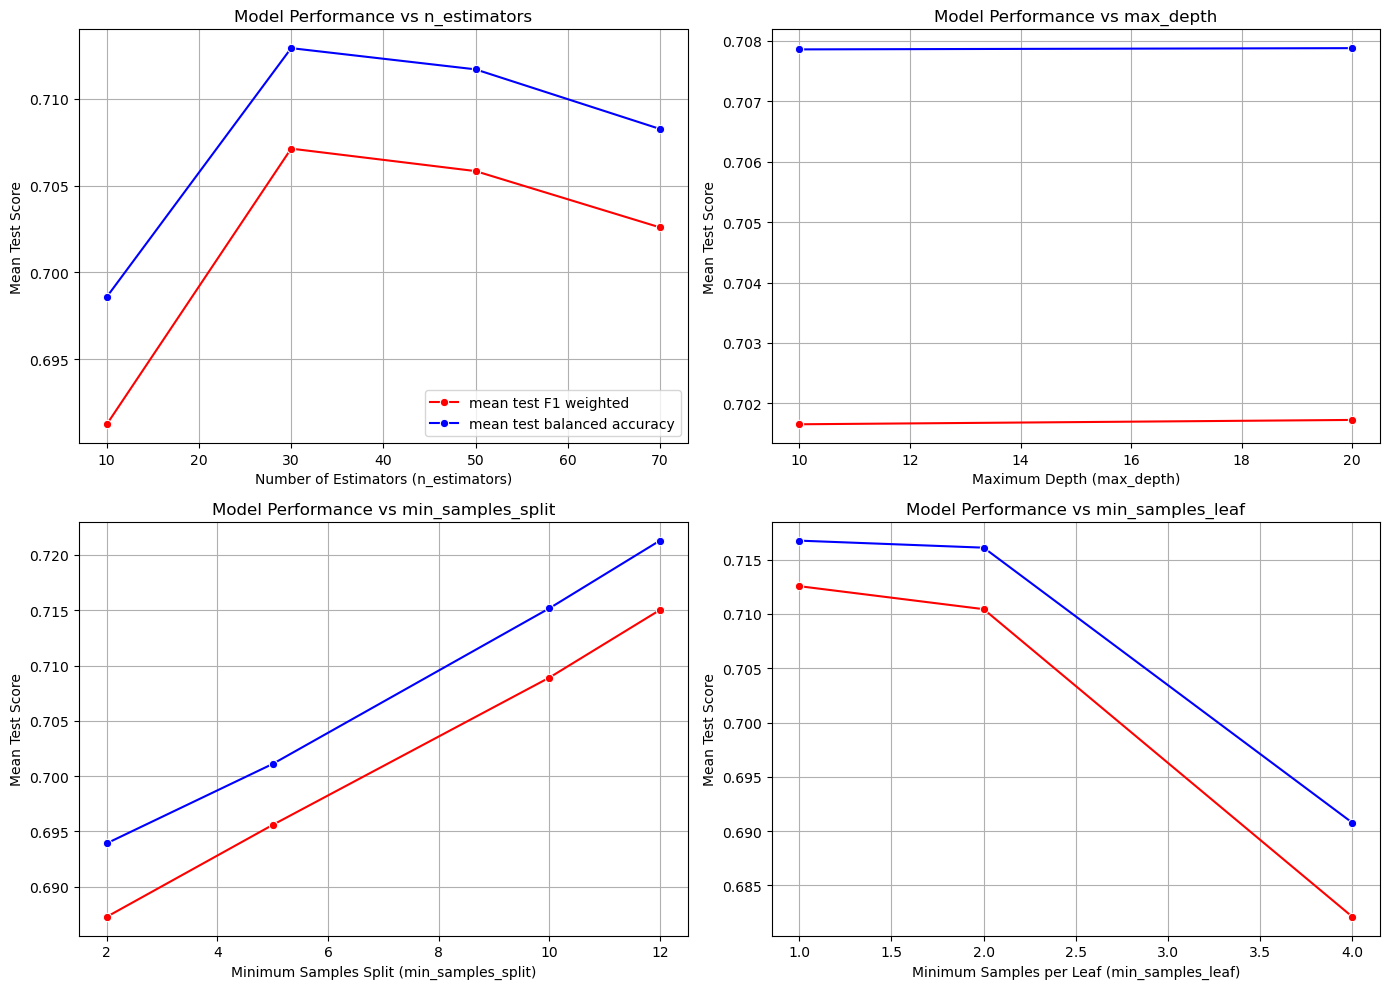

In [24]:
#visualising the Grid Search results

# Assuming grid_search.cv_results_ contains the results of GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)
# Set up the figure with 2 rows and 2 columns
plt.figure(figsize=(14, 10))
# Plot 1: Performance vs n_estimators
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
plt.title('Model Performance vs n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score')
plt.legend(labels = ['mean test F1 weighted', 'mean test balanced accuracy'], loc='best')
plt.grid(True)
# Plot 2: Performance vs max_depth
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='param_max_depth', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_max_depth', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
plt.title('Model Performance vs max_depth')
plt.xlabel('Maximum Depth (max_depth)')
plt.ylabel('Mean Test Score')
plt.grid(True)
# Plot 3: Performance vs min_samples_split
plt.subplot(2, 2, 3)
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
plt.title('Model Performance vs min_samples_split')
plt.xlabel('Minimum Samples Split (min_samples_split)')
plt.ylabel('Mean Test Score')
plt.grid(True)
# Plot 4: Performance vs min_samples_leaf
plt.subplot(2, 2, 4)
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_f1_weighted', marker='o', color='red', ci=None)
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_balanced_accuracy', marker='o', color='blue', ci=None)
plt.title('Model Performance vs min_samples_leaf')
plt.xlabel('Minimum Samples per Leaf (min_samples_leaf)')
plt.ylabel('Mean Test Score')
plt.grid(True)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

5c. Model Tuning: Applying the best hyperparameters to the test data set

In [25]:
dict_weights = {0:1, 1: 1, 2:2} #giving more weight to the minority category

#best hyperparameters 
RFmodel_tuned = RandomForestClassifier(
  n_estimators=30,
  max_depth = 20,
  min_samples_split=10,
  min_samples_leaf=1,
  max_features= None,
  class_weight=dict_weights,
  random_state=42)

# Train the model on the training data 
RFmodel_tuned.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_tuned = RFmodel_tuned.predict(X_test)
y_pred_prob_tuned = RFmodel_tuned.predict_proba(X_test)[:, 1]  #prediction probabilities for each data point

# Calculate accuracy on the validation set
accuracy_test = accuracy_score(y_test, y_pred_tuned)
f1_scores_test = f1_score(y_test, y_pred_tuned,average='weighted')

print(f"Tuned Model Test Set Accuracy: {accuracy_test:.2f}")
print(f"Tuned Model Test Set F1 score: {f1_scores_test:.2f}")


Tuned Model Test Set Accuracy: 0.79
Tuned Model Test Set F1 score: 0.80


5d. Assessing the Performance of the Tuned Model

In [26]:
#printing classification report
print(classification_report(y_pred_tuned, y_test))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       0.76      0.80      0.78        20
           2       0.62      0.45      0.53        11

    accuracy                           0.79        47
   macro avg       0.76      0.75      0.75        47
weighted avg       0.77      0.79      0.78        47



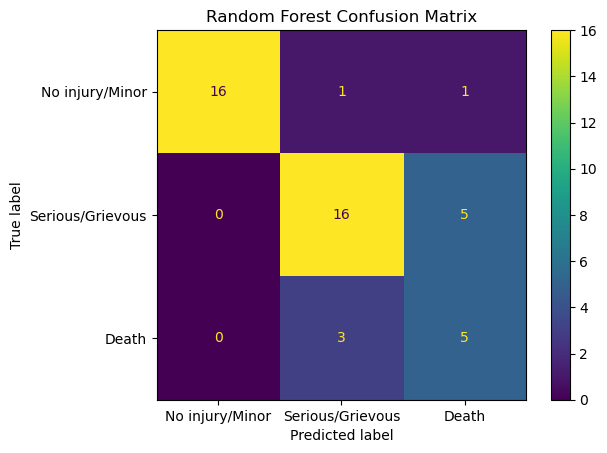

In [27]:
cm = confusion_matrix(y_test, y_pred_tuned)
cm_labels = pd.DataFrame(data=cm, index =['No injury/Minor','Serious/Grievous','Death'], columns=['No injury/Minor','Serious/Grievous','Death'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cm_labels)
disp.plot()
disp.ax_.set_title("Random Forest Confusion Matrix")
plt.show()


5d. Binarized class prediction

In [ ]:
#check with scaling

In [58]:
dict_weights = {0:1, 1: 1, 2:2} #giving more weight to the minority category

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

n_classes = len(set(y_test))

y_train_bin = label_binarize(y_train, classes=[*range(n_classes)])
y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])

#best hyperparameters 
RFmodel_tuned = OneVsRestClassifier(RandomForestClassifier(
  n_estimators=30,
  max_depth = 20,
  min_samples_split=10,
  min_samples_leaf=1,
  max_features= None,
  class_weight=dict_weights,
  random_state=42))

# Train the model on the training data 
RFmodel_tuned.fit(X_train, y_train_bin)

# Make predictions on the validation set
y_pred_tuned_bin = RFmodel_tuned.predict(X_test)
#y_score_bin = RFmodel_tuned.predict_proba(X_test)[:, 1]  #prediction probabilities for each data point
y_score_bin = RFmodel_tuned.predict_proba(X_test)  #prediction probabilities for each data point

# Calculate accuracy on the validation set
accuracy_test = accuracy_score(y_test_bin, y_pred_tuned_bin)
f1_scores_test = f1_score(y_test_bin, y_pred_tuned_bin,average='weighted')

print(f"Tuned Model Test Set Accuracy: {accuracy_test:.2f}")
print(f"Tuned Model Test Set F1 score: {f1_scores_test:.2f}")

Tuned Model Test Set Accuracy: 0.81
Tuned Model Test Set F1 score: 0.80


In [59]:
y_score_bin

array([[0.07960824, 0.62744709, 0.31441137],
       [0.        , 0.97245791, 0.05835017],
       [0.07922078, 0.94711941, 0.0047619 ],
       [0.1386661 , 0.17871841, 0.71655363],
       [0.99333333, 0.00208333, 0.01074074],
       [1.        , 0.        , 0.        ],
       [0.11932239, 0.5199124 , 0.3701455 ],
       [0.81170876, 0.14397006, 0.05845155],
       [0.05001316, 0.75473615, 0.19494856],
       [0.02424242, 0.83676416, 0.19507955],
       [0.11932239, 0.5199124 , 0.3701455 ],
       [0.        , 0.85104988, 0.25026295],
       [0.05001316, 0.75473615, 0.19494856],
       [0.03585082, 0.57604978, 0.36699967],
       [0.11932239, 0.5199124 , 0.3701455 ],
       [0.74197797, 0.1049476 , 0.10956321],
       [0.8742749 , 0.01856061, 0.06797536],
       [0.05001316, 0.75473615, 0.19494856],
       [0.07960824, 0.62744709, 0.31441137],
       [0.95298942, 0.12540945, 0.        ],
       [0.0421645 , 0.48565837, 0.30287037],
       [0.07960824, 0.62744709, 0.31441137],
       [0.

In [53]:
y_pred_prob_tuned_bin

array([0.62744709, 0.97245791, 0.94711941, 0.17871841, 0.00208333,
       0.        , 0.5199124 , 0.14397006, 0.75473615, 0.83676416,
       0.5199124 , 0.85104988, 0.75473615, 0.57604978, 0.5199124 ,
       0.1049476 , 0.01856061, 0.75473615, 0.62744709, 0.12540945,
       0.48565837, 0.62744709, 0.74304432, 0.75473615, 0.59272021,
       0.00208333, 0.62744709, 0.97245791, 0.62014805, 0.62951299,
       0.51859563, 0.68552979, 0.00208333, 0.74349276, 0.97245791,
       0.12749278, 0.21728984, 0.75473615, 0.        , 0.01856061,
       0.57604978, 0.62744709, 0.        , 0.57604978, 0.01856061,
       0.        , 0.00208333])

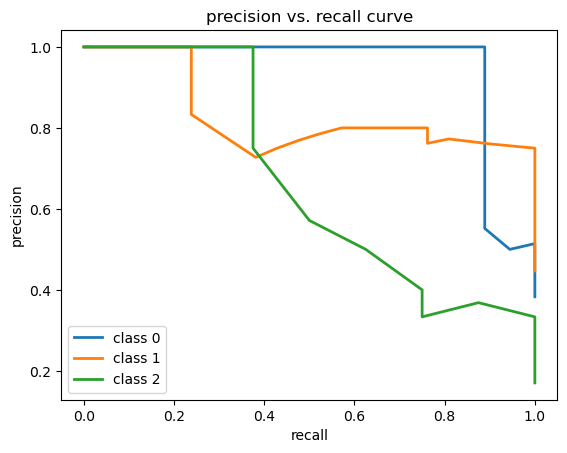

In [ ]:
#https://www.blog.trainindata.com/precision-recall-curves/

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

n_classes = len(set(y_test))

y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
y_pred_tuned_bin = label_binarize(y_pred_tuned, classes=[*range(n_classes)])

precision = dict()
recall = dict()

# Generate precision-recall curve

for i in range(n_classes):
    precision[i], recall[i],_ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score_bin[:,i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()





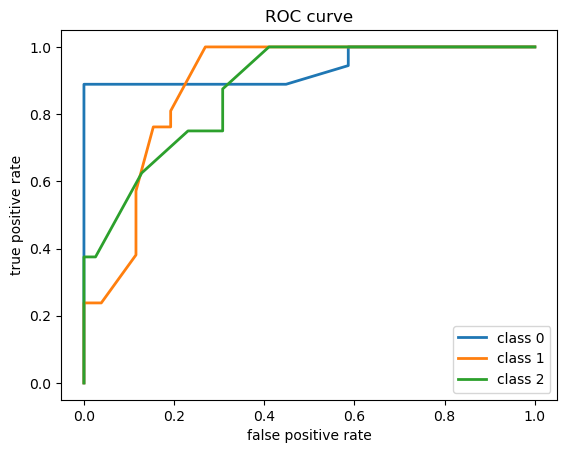

In [61]:
# roc curve
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i],
                                  y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

KeyError: 2

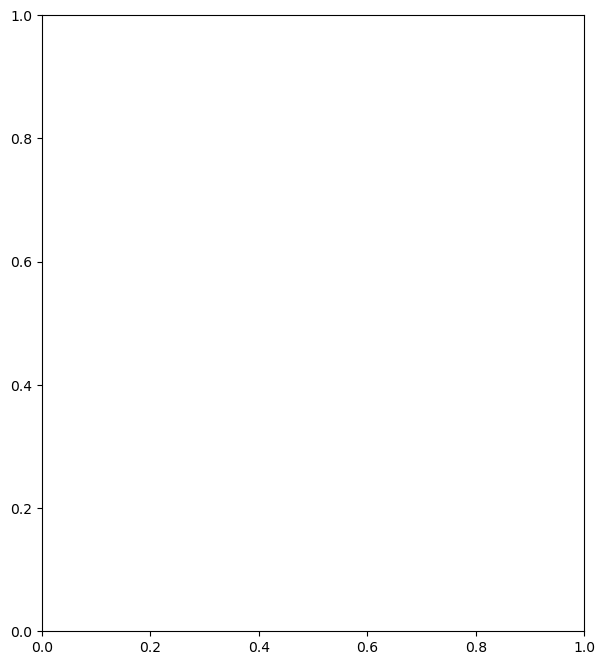

In [38]:
from itertools import cycle

precision = dict()
recall = dict()

_, ax = plt.subplots(figsize=(7, 8))

colors = cycle(["navy", "turquoise", "darkorange"])
display = PrecisionRecallDisplay(recall[i],precision[i])
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(recall[i],precision[i])
    display.plot(
        ax=ax, name=f"Precision-recall for class {i}", color=color, despine=True
    )
   
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [39]:
i

2

In [34]:
recall

{0: array([1.        , 0.88888889, 0.        ]),
 1: array([1.        , 0.76190476, 0.        ]),
 2: array([1.   , 0.625, 0.   ])}

In [33]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html
#https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

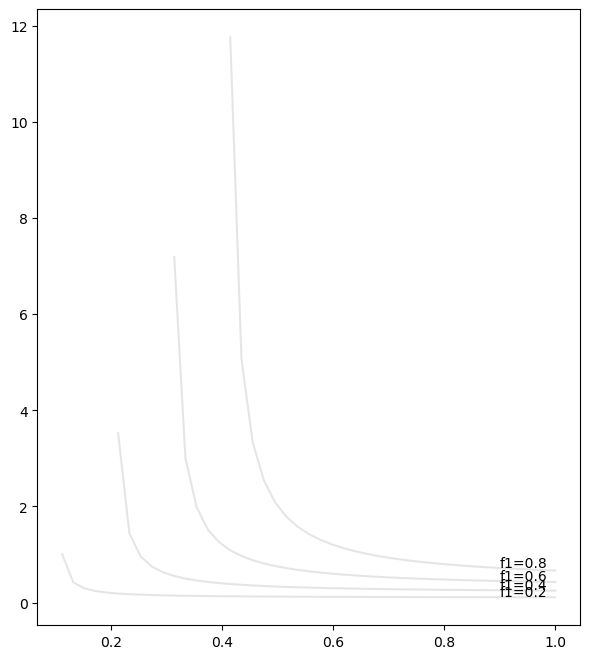

In [ ]:
from itertools import cycle

import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(
        ax=ax, name=f"Precision-recall for class {i}", color=color, despine=True
    )

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

In [ ]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
#precision-recall for multiclass

In [ ]:
reclass_injury = {0:0,1:1,2:1}
y_test= y_test.map(reclass_injury)

y_pred_tuned1 = y_pred_tuned.reshape([47, ])
y_pred_tuned1[y_pred_tuned1 > 1] = 1 
y_pred_tuned1

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0], dtype=int64)

Feature Importance Metrics

In [ ]:
# Gini Importance
targets = np.array(['No injury/Minor','Serious/Grievous','Death'])
features = np.array(x_params)

importances = RFmodel_tuned.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
1,affected_party,0.389977
0,primary_accident_type_code,0.302324
3,vehicle_type_score,0.164252
4,age_min_encoded,0.091886
2,rain_today,0.051561


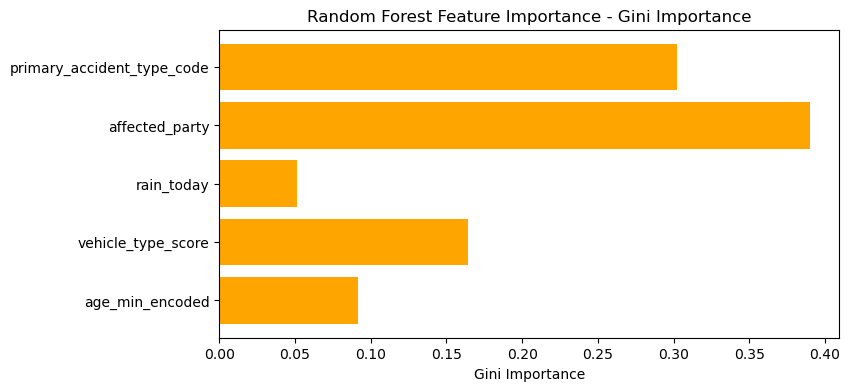

In [ ]:
plt.figure(figsize=(8, 4))
plt.barh(features, importances, color='orange')
plt.xlabel('Gini Importance')
plt.title('Random Forest Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
#permutation importance

from sklearn.inspection import permutation_importance
result = permutation_importance(
    RFmodel_tuned, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': features, 'Permutation Importance': result.importances_mean}).sort_values(
    'Permutation Importance', ascending=False)
perm_imp_df

,Feature,Permutation Importance
1,affected_party,0.282979
0,primary_accident_type_code,0.105674
4,age_min_encoded,0.050355
3,vehicle_type_score,0.043262
2,rain_today,0.029078


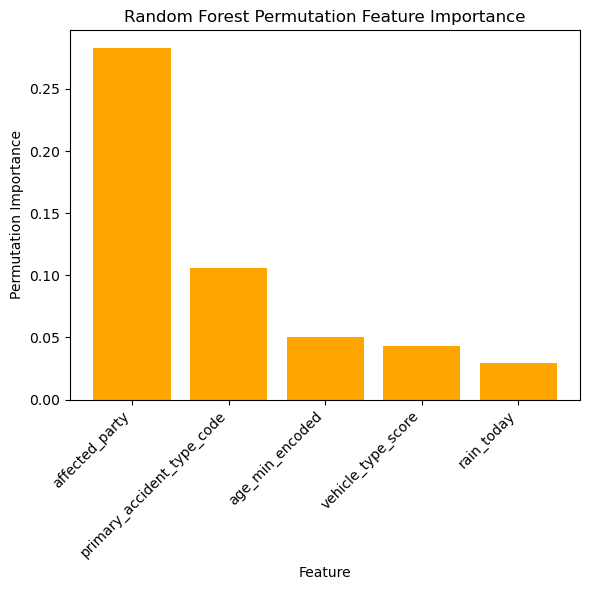

In [ ]:
plt.figure(figsize=(6, 6))
plt.bar(perm_imp_df['Feature'], perm_imp_df['Permutation Importance'],color='orange')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Random Forest Permutation Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Tree Visualisation

In [ ]:
# Extract an individual decision tree from the Random Forest
from sklearn import tree
import graphviz
individual_tree = RFmodel_tuned.estimators_[0]  # Get the first tree (you can choose any index)


# Export the decision tree as a DOT file
dot_data = tree.export_graphviz(individual_tree, out_file=None,
                feature_names=features,
                class_names=targets,
                rounded=True, filled=True)

graph = graphviz.Source(dot_data) 
graph 


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH